<a href="https://colab.research.google.com/github/rimchristian/Hotel-Reservation-ML-Model/blob/main/hotelbooking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project Description**

### **Task**
The aim is to predict if the customer is going to honor the reservation or cancel it?

###**Import Libraries**

In [181]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatPlotLib
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns

## Preprocessing
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

## Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold


# Boosting Algorithm 
from sklearn.ensemble import GradientBoostingClassifier


## Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
RocCurveDisplay, roc_auc_score, PrecisionRecallDisplay

from sklearn import metrics
## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

### **Functions**

In [196]:
## Define a function that takes in arguments and prints out a classification report and confusion matrix
def evaluate_classification(model, X_test, y_test, cmap='Greens',
                            normalize=None, classes=None, figsize=(20,5)):
  """Takes as arguments: a model, features, and labels
  Prints a classification report, confusion matrix
  Optional arguments: 
    cmap: colormap 
    normalize: confusion matrix normalization ['true', 'pred', 'all' or None]
    classes: ordered list of class labels
    figsize: size of figure"""
  test_preds = model.predict(X_test)
  print(metrics.classification_report(y_test, test_preds, 
                                      zero_division=0,
                                      target_names=classes))
  
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=cmap, 
                                display_labels=classes,
                                normalize='true')
  plt.show()  

In [190]:
## Create a function to display the classification metrics of a model
def classification_metrics(model, X_test, y_test, label='Test Data', 
                             figsize=(15,5), normalize='true',
                             cmap='Greens'): 
                             
    fig, axes = plt.subplots(1,2, figsize=figsize)

    ## Get the predictions
    y_pred = model.predict(X_test)
     
   ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, 
                normalize=normalize, cmap=cmap,              
                ax=axes[0])    
    
    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])
    plt.show()
    

# **Load and Inspect the Data**

In [116]:
filename = '/content/Hotel_Reservations.csv'
df = pd.read_csv(filename)

In [117]:
# display the first 5 rows
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [118]:
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 36275 rows, and 19 columns.
The rows represent 36275 observations, and the columns represent 18 features and 1 target variable.


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

There are 19 variables in this dataset, with a total of 36,275 observations. "Booking_status" is the target variable, which has two categories encoded as 1 (canceled) and 0 (non-canceled). 

### **Inspecting**

In [120]:
# display the descriptive statistics for the numeric columns
df.describe(include='number')

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [121]:
# display the descriptive statistics for the categorical columns
df.describe(include='object')

,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
count,36275,36275,36275,36275,36275
unique,36275,4,7,5,2
top,INN00001,Meal Plan 1,Room_Type 1,Online,Not_Canceled
freq,1,27835,28130,23214,24390


# **Clean the Data**

## **Remove Unnecessary Columns**

In [122]:
# drop columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

## **Remove Unnecessary Rows**

In [123]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


## **Inspect Column Names for Errors**

In [124]:
df.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

## **Inspect Values for Errors**

In [125]:
df.describe(include='number')

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


## **Missing Values**

In [126]:
# Display the total number of missing values 
print(f'There are {df.isna().sum().sum()} missing values.')

There are 0 missing values.


In [127]:
#Checking null percentage
df.isnull().mean()*100

Booking_ID                              0.0
no_of_adults                            0.0
no_of_children                          0.0
no_of_weekend_nights                    0.0
no_of_week_nights                       0.0
type_of_meal_plan                       0.0
required_car_parking_space              0.0
room_type_reserved                      0.0
lead_time                               0.0
arrival_year                            0.0
arrival_month                           0.0
arrival_date                            0.0
market_segment_type                     0.0
repeated_guest                          0.0
no_of_previous_cancellations            0.0
no_of_previous_bookings_not_canceled    0.0
avg_price_per_room                      0.0
no_of_special_requests                  0.0
booking_status                          0.0
dtype: float64

# **Visualization**

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

### **Univariate Visuals**

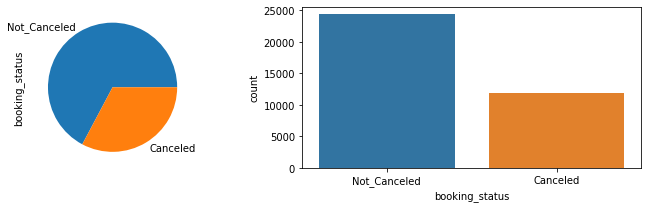

In [129]:
# a chart for distribution of the target variable
fig = plt.figure(figsize=(10,3))
fig.add_subplot(1,2,1)
a = df['booking_status'].value_counts(normalize=True).plot.pie()
fig.add_subplot(1,2,2)
churnchart=sns.countplot(x=df['booking_status'])
plt.tight_layout()
plt.show()

The two classes were not distributed evenly so the data may be imbalanced. It seems there are more people who didn't cancel. We will see why customer who did cancel their reservation. 

In [130]:
df['booking_status'].value_counts()
#df['booking_status'].replace({'Canceled':1,'Not_Canceled':0}, inplace=True)
df['booking_status'].value_counts()


Not_Canceled    24390
Canceled        11885
Name: booking_status, dtype: int64

Text(0.5, 1.0, 'Number of Adults and Children')

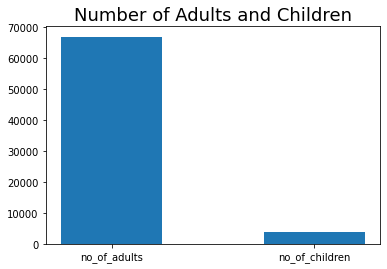

In [131]:
fig, ax = plt.subplots()
ax.bar(np.arange(2), [df['no_of_adults'].sum(), df['no_of_children'].sum()], width=0.5)
plt.xticks(np.arange(2), ('no_of_adults','no_of_children'))
plt.title('Number of Adults and Children', fontsize=18)

More adults has booked a room than children. 

Room Type 6 is the most expensive one, followed by Room Type 7.  Room Type 2 or Type 3 is the cheapest one. 

Text(0.5, 1.0, 'Booking Distribution by the days of Months')

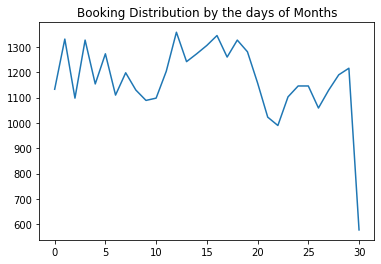

In [132]:
plt.plot(df['arrival_date'].value_counts().sort_index().values)
plt.title('Booking Distribution by the days of Months')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of Bookings by Year')

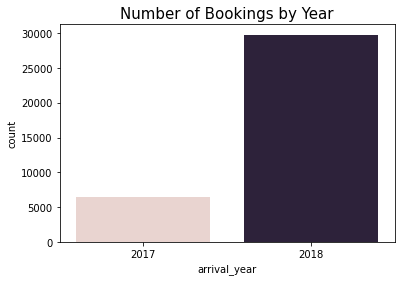

In [133]:
ax = sns.countplot(df['arrival_year'], palette=sns.cubehelix_palette(2))
plt.title('Number of Bookings by Year', fontsize=15)

- Our samples are mostly in 2018. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Cancelation Situation by Months')

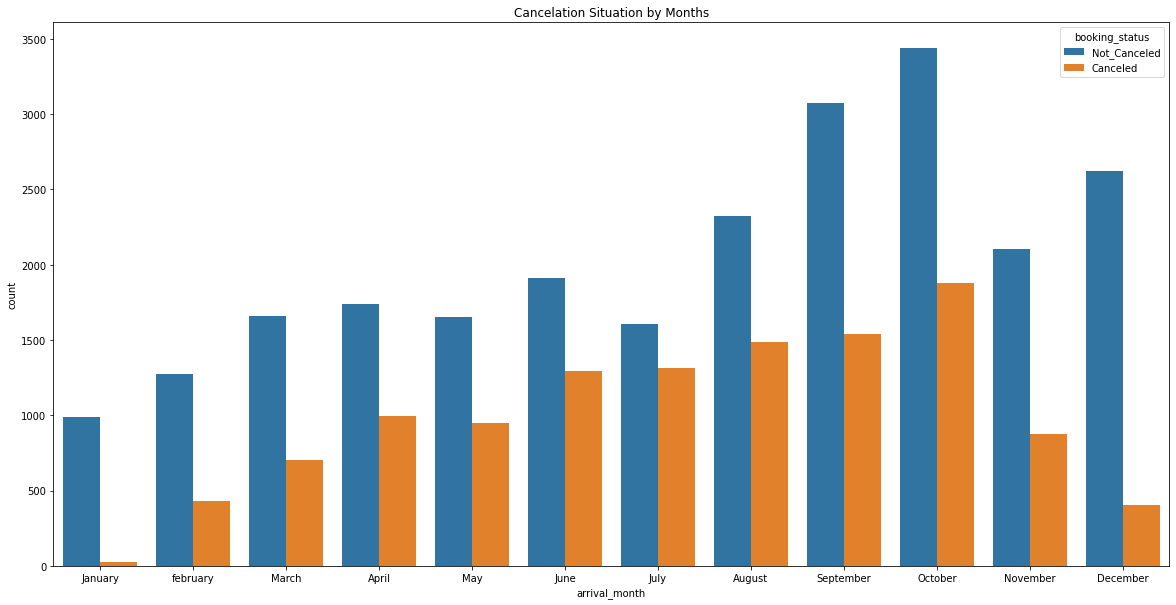

In [134]:
plt.figure(figsize=(20,10))
sns.countplot(df["arrival_month"], hue=df["booking_status"])
plt.xticks(np.arange(0,12),["January", "february", "March", "April","May","June",
"July","August","September","October","November","December"])
plt.title("Cancelation Situation by Months")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of Special Request - Cancellation')

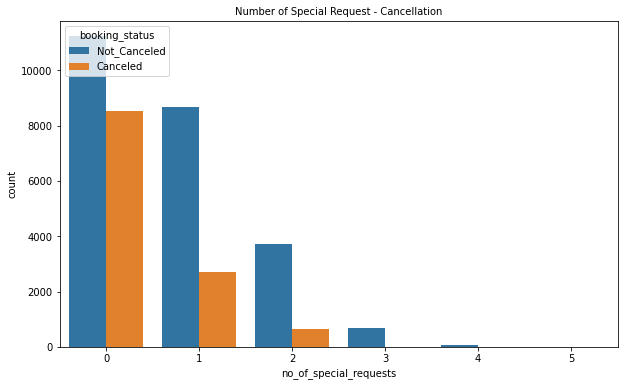

In [135]:
plt.figure(figsize=(10,6))
sns.countplot(df['no_of_special_requests'], hue=df['booking_status'])
plt.title('Number of Special Request - Cancellation', fontsize=10)

This chart shows that the cancelation rate is higher for the guests who didn have a special request. 



In [136]:
df.groupby('repeated_guest')['booking_status'].value_counts()

repeated_guest  booking_status
0               Not_Canceled      23476
                Canceled          11869
1               Not_Canceled        914
                Canceled             16
Name: booking_status, dtype: int64

- The cancelation rate is higher for not repeated guests compared to repeated ones. 
- Most of the repeated guests didn't cancel. A good sign.  

### **Identifying Outliers**

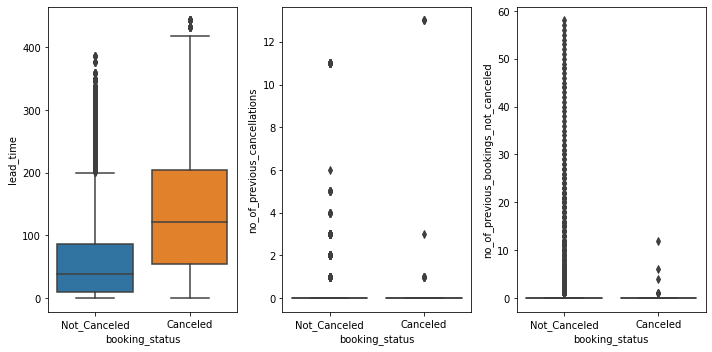

In [137]:
# visualize correlation between cancellation and other features
fig=plt.figure(figsize=(10,5))
fig.add_subplot(1,3,1)
ar_6=sns.boxplot(x=df["booking_status"],y=df['lead_time'])
fig.add_subplot(1,3,2)
ar_6=sns.boxplot(x=df["booking_status"],y=df['no_of_previous_cancellations'])
fig.add_subplot(1,3,3)
ar_6=sns.boxplot(x=df["booking_status"],y=df["no_of_previous_bookings_not_canceled"])
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Lead Time by Cancellation')

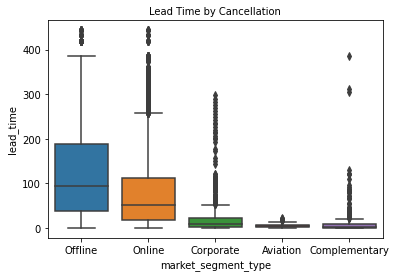

In [138]:
# deploying a boxplot
sns.boxplot(df['market_segment_type'], df['lead_time'])
plt.title('Lead Time by Cancellation', fontsize=10)

This boxplot shows that the offline has the most lead time. The lead time is the period between the booking time and arrival date. More people reserve in person than online. Although, there are more outliers at higher counts for the online box. Could be a good insight. 

There are outliers in this data. 

I can also say that as the lead time increases, the possibiity of canceling increases as well. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Adults reserving on week days')

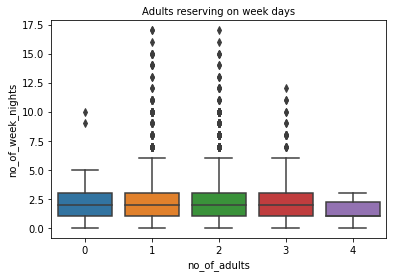

In [139]:
# deploying a boxplot
sns.boxplot(df['no_of_adults'], df['no_of_week_nights'])
plt.title('Adults reserving on week days', fontsize=10)


Shows the count of the number of week nights for each party. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Booking Status by price')

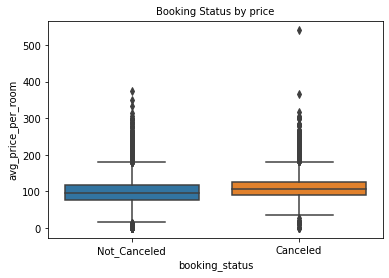

In [140]:
# deploying a boxplot
sns.boxplot(df['booking_status'], df['avg_price_per_room'])
plt.title('Booking Status by price', fontsize=10)

It seems to be equal based on the average price per room for both cancel and no cancel results. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Repeated guests reserving on weekdays')

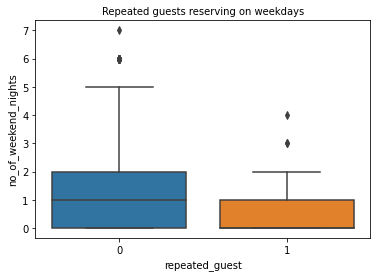

In [141]:
# deploying a boxplot on repeated guests and number of weekened nights
sns.boxplot(df['repeated_guest'], df['no_of_weekend_nights'])
plt.title('Repeated guests reserving on weekdays', fontsize=10)

### **Finding Correlations**

In [142]:
# identifying the correlations
df.corr()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
no_of_adults,1.000000,-0.019787,0.103316,0.105622,0.011429,0.097287,0.076719,0.021841,0.026338,-0.192277,-0.047426,-0.119166,0.296886,0.189401
no_of_children,-0.019787,1.000000,0.029478,0.024398,0.034244,-0.047091,0.045983,-0.003076,0.025482,-0.036348,-0.016390,-0.021189,0.337728,0.124486
no_of_weekend_nights,0.103316,0.029478,1.000000,0.179577,-0.031111,0.046595,0.055357,-0.009894,0.027304,-0.067107,-0.020690,-0.026312,-0.004525,0.060593
no_of_week_nights,0.105622,0.024398,0.179577,1.000000,-0.048784,0.149650,0.032672,0.037376,-0.009305,-0.099764,-0.030080,-0.049344,0.022753,0.045994
required_car_parking_space,0.011429,0.034244,-0.031111,-0.048784,1.000000,-0.066445,0.015684,-0.015505,-0.000037,0.110909,0.027106,0.063810,0.061304,0.087922
lead_time,0.097287,-0.047091,0.046595,0.149650,-0.066445,1.000000,0.143439,0.136814,0.006479,-0.135984,-0.045723,-0.078137,-0.062596,-0.101645
arrival_year,0.076719,0.045983,0.055357,0.032672,0.015684,0.143439,1.000000,-0.339689,0.018849,-0.018175,0.003919,0.026422,0.178605,0.053205
arrival_month,0.021841,-0.003076,-0.009894,0.037376,-0.015505,0.136814,-0.339689,1.000000,-0.042780,0.000341,-0.038615,-0.010718,0.054423,0.110552
arrival_date,0.026338,0.025482,0.027304,-0.009305,-0.000037,0.006479,0.018849,-0.042780,1.000000,-0.015949,-0.012542,-0.001498,0.017898,0.018352
repeated_guest,-0.192277,-0.036348,-0.067107,-0.099764,0.110909,-0.135984,-0.018175,0.000341,-0.015949,1.000000,0.390810,0.539156,-0.174900,-0.011820


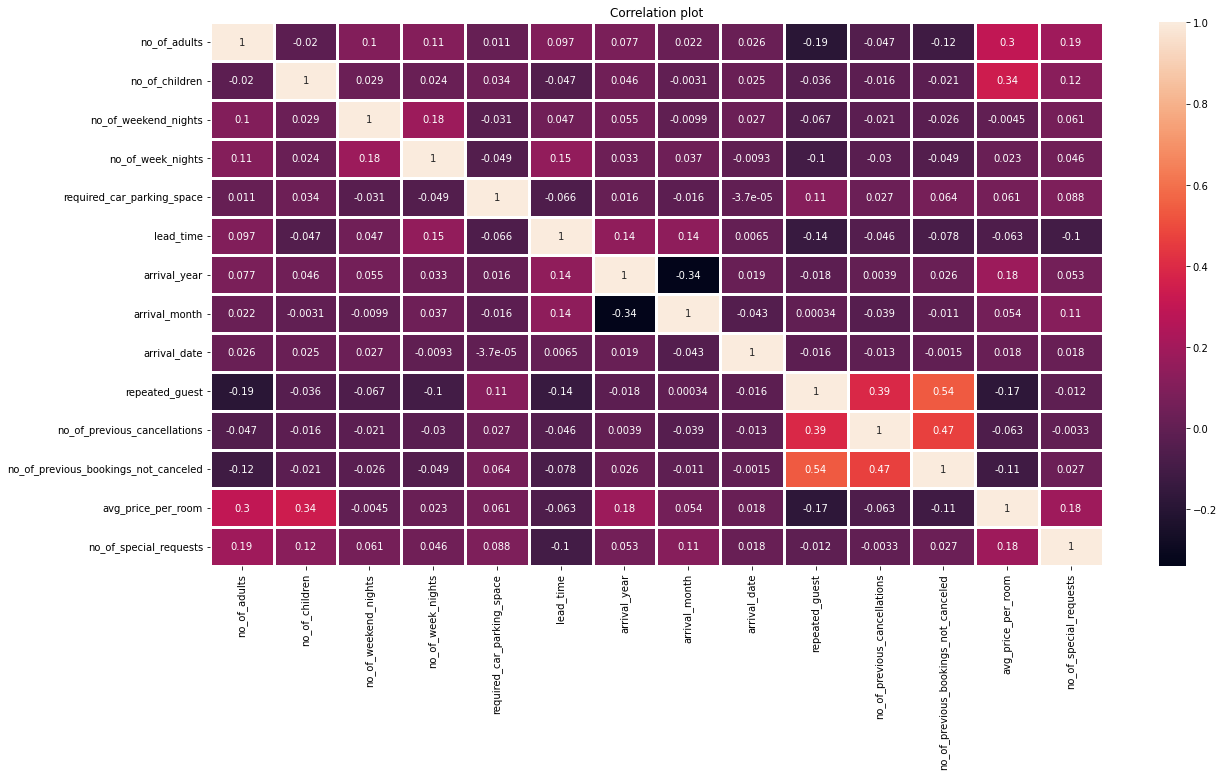

In [143]:
# Increase the size of the heatmap.
plt.figure(figsize=(20,10))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), linewidths=3, annot=True)
plt.title("Correlation plot")
plt.show()

None of these features are highly correlated to each other, except the following: 
repeated_guest, # of previous cancellations, and # of previous bookings not cancelled.  

In [144]:
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

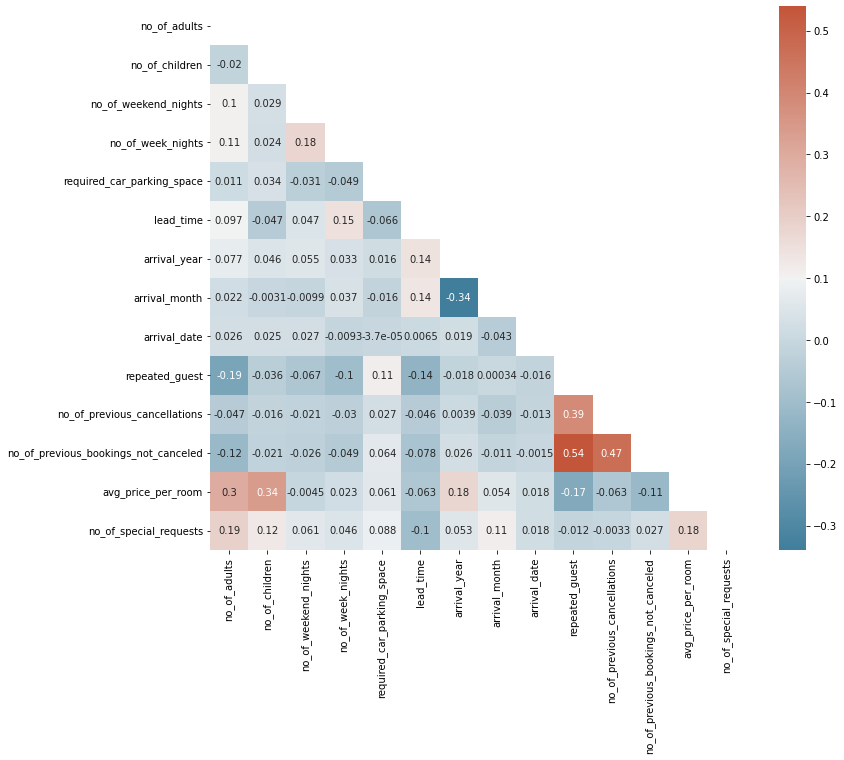

In [145]:
#Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))

mask = np.triu(np.ones_like(df.corr(), dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df.corr(), annot=True, mask = mask, cmap=cmap)

Correlation Summary:
- There isn't much of a correlation between the target and the feature variables.  The booking status and the lead time had a correlation of 0.44, which is pretty moderate.
- The other important thing to note is  that there is no correlation greater than 60%. The highest was 0.54 between repeated guests and number of previous bookings not canceled.  I have a pie chart to demonstrate the cancelation chart for repeated guests. 

Text(0.5, 1.0, 'Distribution in # of days between date of booking and arrival date')

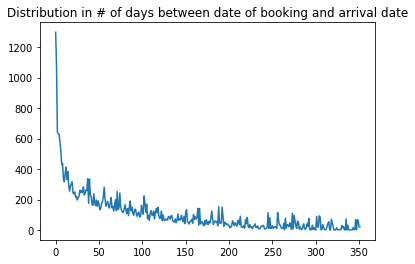

In [146]:
plt.plot(df['lead_time'].value_counts().sort_index().values)
plt.title('Distribution in # of days between date of booking and arrival date')

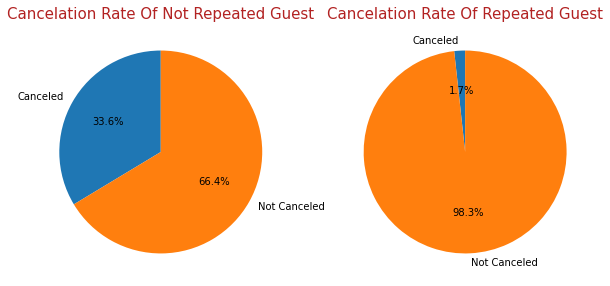

In [147]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'aspect': 'equal'})
ax[0].pie([11896,23476], labels=["Canceled","Not Canceled"], autopct='%1.1f%%', startangle=90)
ax[0].set_title("Cancelation Rate Of Not Repeated Guest",color="#b22222",fontsize=15)
ax[1].pie([16,914], labels=["Canceled","Not Canceled"], autopct='%1.1f%%', startangle=90)
ax[1].set_title("Cancelation Rate Of Repeated Guest",color="#b22222",fontsize=15);

This pie chart displays a nice visualization that shows cancellation rates for repeated guests and not repeated guests. We can see that for repeated guests, they mostly keep their reservation. For first time guests, there is a 33% cancelation rate and 66% didn't cancel. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Average Prices of Each Room Types')

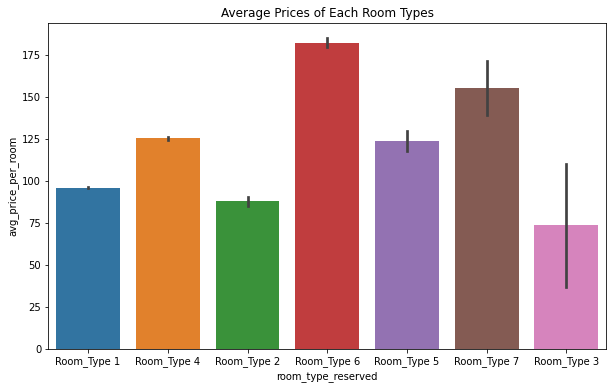

In [148]:
plt.figure(figsize=(10,6))
ax =  sns.barplot(df['room_type_reserved'], df['avg_price_per_room'])
plt.title('Average Prices of Each Room Types')

This shows the average prices for each room types.  The most expensive room was Room Type 6, $177.  Room Type 7 was also one of the popular options as wel. Room Type 3 had the lowest average price. 

In [149]:
# ordinal encoding for 'type of meal plan'
df['type_of_meal_plan'].value_counts()
df['type_of_meal_plan'] = df['type_of_meal_plan'].replace({'Meal Plan 1':1, 'Meal Plan 2':2,'Meal Plan 3':3,'Not Selected':0})
df['type_of_meal_plan'].value_counts()

1    27835
0     5130
2     3305
3        5
Name: type_of_meal_plan, dtype: int64

In [150]:
# ordinal encoding for 'room_type_reserved'
df['room_type_reserved'].value_counts()
df['room_type_reserved'] = df['room_type_reserved'].replace({'Room_Type 1':1, 'Room_Type 2':2,'Room_Type 3':3,'Room_Type 4':4,'Room_Type 5':5,
                                                             'Room_Type 6':6,'Room_Type 7':7})
df['room_type_reserved'].value_counts()

1    28130
4     6057
6      966
2      692
5      265
7      158
3        7
Name: room_type_reserved, dtype: int64

In [151]:
df['market_segment_type'].value_counts()
df['market_segment_type'] = df['market_segment_type'].replace({'Online':1, 'Offline':2,'Corporate':3,'Complementary':4,'Aviation':5})
df['market_segment_type'].value_counts()


1    23214
2    10528
3     2017
4      391
5      125
Name: market_segment_type, dtype: int64

In [152]:
# ordinal encoding for 'booking tatus'
df['booking_status'].value_counts()
df['booking_status'] = df['booking_status'].replace({'Canceled':1,'Not_Canceled':0})
df['booking_status'].value_counts()

0    24390
1    11885
Name: booking_status, dtype: int64

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  int64  
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  int64  
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

# **Model Validation Split**

In [154]:
df['booking_status'].value_counts(normalize=False)

0    24390
1    11885
Name: booking_status, dtype: int64

In [155]:
df['booking_status'].value_counts(normalize=True)

0    0.672364
1    0.327636
Name: booking_status, dtype: float64

# **Preprocessing**

In [156]:
# separating the feature and target column 
target = 'booking_status'
labels = ['Not_Canceled', 'Canceled']

X = df.drop(columns=[target, 'Booking_ID','no_of_children'], axis=1)
y = df[target]

In [157]:
# Split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [158]:
# get the shape of train and test data
print('train size X: ',X_train.shape)
print('train size y: ',y_train.shape)
print('train size X: ',X_test.shape)
print('train size y: ',y_test.shape)

train size X:  (27206, 16)
train size y:  (27206,)
train size X:  (9069, 16)
train size y:  (9069,)


In [159]:
# instantiate the column selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

In [160]:
# feature scaling and one hot encoding 
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [161]:
# create tuples
num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)

In [187]:
# create the preprocessor 
preproccessor = make_column_transformer(num_tuple,cat_tuple,remainder='drop')

# **Modeling**

## **Logistic Regression Model**

In [163]:
# making an instance of a model 
logreg = LogisticRegression()

# create a pipeline
logreg_pipe = make_pipeline(scaler,logreg)

# fit the log reg model
logreg_pipe.fit(X_train,y_train)
print(logreg_pipe.score(X_train,y_train))
print(logreg_pipe.score(X_test,y_test))

0.8047857090347718
0.8048296394310288


In [164]:
logreg_train_preds = logreg_pipe.predict(X_train)
logreg_test_preds = logreg_pipe.predict(X_test)

### **Metrics**

In [165]:
# creating multiple classification report
print(classification_report(y_test, logreg_test_preds))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      6043
           1       0.76      0.61      0.68      3026

    accuracy                           0.80      9069
   macro avg       0.79      0.76      0.77      9069
weighted avg       0.80      0.80      0.80      9069



In [166]:
print('f1 score for base model is :', f1_score(y_test,logreg_test_preds))

f1 score for base model is : 0.6773605541378053


We got a 0.68 f1-score on our model created using default parameters. 
I am going to increase my model performance and evaluate again. 

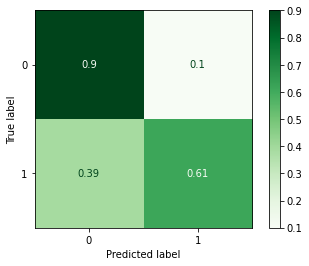

In [167]:
# create a confusion matrix with the test data
ConfusionMatrixDisplay.from_predictions(y_test, logreg_test_preds,
                                         normalize='true',cmap='Greens');

#### **Balancing the class weight**

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      6043
           1       0.64      0.77      0.70      3026

    accuracy                           0.78      9069
   macro avg       0.76      0.78      0.76      9069
weighted avg       0.79      0.78      0.78      9069



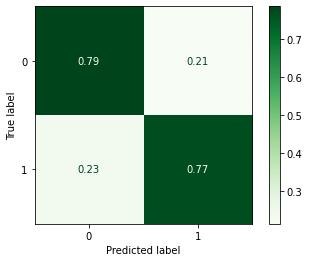

In [198]:
#Instantiate the pipeline with the scaler and weighted model
log_reg_weighted = LogisticRegression(max_iter=1000, class_weight='balanced')

# creating a pipeline
log_reg_weighted_pipe = make_pipeline(scaler, log_reg_weighted)

#Fit and evaluate the model
log_reg_weighted_pipe.fit(X_train, y_train)

# Evaluate the logistic regression pipe using function
evaluate_classification(log_reg_weighted_pipe, X_test, y_test)

{0.0001: 0.6663358694453633,
 0.001: 0.783658617267615,
 0.01: 0.8024037931414709,
 0.1: 0.8049399051714632,
 1: 0.8048296394310288,
 10: 0.8048296394310288,
 100: 0.8048296394310288,
 1000: 0.8048296394310288}

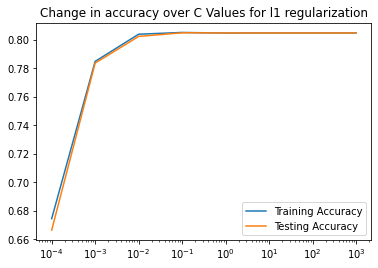

In [169]:
# create a list of c values and empty list for scores
c_values = [0.0001,0.001,0.01,0.1,1,10,100,1000]
train_scores = []
test_scores = []
# iterating over the c values
for c in c_values:

  # instantiate a model with each value of c and fit the model
  log_reg = LogisticRegression(C=c, max_iter=1000,solver='liblinear', penalty='l1')
  log_reg_pipe = make_pipeline(scaler, log_reg)
  log_reg_pipe.fit(X_train,y_train)
  test_preds_l1 =log_reg_pipe.predict(X_test)


  # add the training and testing scores to the score lists
  train_scores.append(log_reg_pipe.score(X_train,y_train))
  test_scores.append(log_reg_pipe.score(X_test,y_test))

# plot the change in accuracy as the c values changes
figm,ax = plt.subplots(1,1)
ax.plot(c_values,train_scores,label='Training Accuracy')
ax.plot(c_values,test_scores,label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C Values for l1 regularization')
ax.legend()

ax.set_xscale('log')

# print a dictionary of values of c and accuracy scores
{c:score for c, score in zip(c_values,test_scores)} 

{0.0001: 0.7236740544712758,
 0.001: 0.7960083801962731,
 0.01: 0.8017421986988643,
 0.1: 0.8050501709118977,
 1: 0.8048296394310288,
 10: 0.8048296394310288,
 100: 0.8048296394310288,
 1000: 0.8048296394310288}

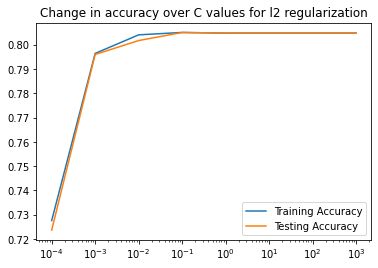

In [170]:
# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
  # instantiate a model with each value of c and fit it on the data
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='lbfgs', penalty='l2')
  log_reg_pipe = make_pipeline(scaler, log_reg)
  log_reg_pipe.fit(X_train, y_train)
 
  # add the training and testing scores to our scores lists
  train_scores.append(log_reg_pipe.score(X_train, y_train))
  test_scores.append(log_reg_pipe.score(X_test, y_test))
  
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l2 regularization')
ax.legend()
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

### **Changing Decision Thresholds**

In [171]:
## get the predicted probabilities insead of predicted classes
train_probs = log_reg_pipe.predict_proba(X_train)
test_probs = log_reg_pipe.predict_proba(X_test)

In [172]:
## display the results
train_probs[:10]

array([[0.34788717, 0.65211283],
       [0.40073926, 0.59926074],
       [0.0763585 , 0.9236415 ],
       [0.68949812, 0.31050188],
       [0.77838036, 0.22161964],
       [0.66779897, 0.33220103],
       [0.8771946 , 0.1228054 ],
       [0.54988192, 0.45011808],
       [0.96717441, 0.03282559],
       [0.70960275, 0.29039725]])

In [173]:
## setting the thresh variable 
thresh = 0.4

# using a list comprehension to apply threshold to 2nd value in each prediction
train_thresh = [1 if x[1] > thresh else 0 for x in train_probs]
test_thresh = [1 if x[1] > thresh else 0 for x in test_probs]

print(f'Predictions with the default decision threshold of .5')
print(logreg_train_preds[:5], '\n')

print(f'Predictions with the default decision threshold of {thresh}')
print(train_thresh[:5], '\n')

print(f'True Labels')
print(y_train[:5].values)



Predictions with the default decision threshold of .5
[1 1 1 0 0] 

Predictions with the default decision threshold of 0.4
[1, 1, 1, 0, 0] 

True Labels
[1 1 1 1 0]


### **Comparing Confusion Matrices**

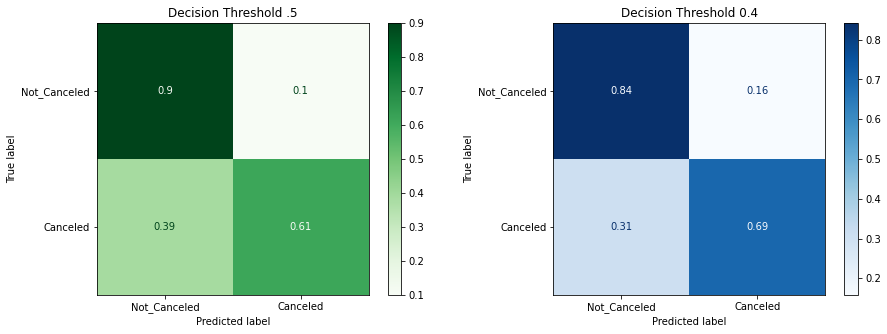

In [174]:
## plotting confusion matrices for both .5 and a 'thresh' thresholds
fig, axes = plt.subplots(1,2, figsize=(15,5))

## Confusion Matrix for default threshold
ConfusionMatrixDisplay.from_predictions(y_test, logreg_test_preds,
                                        normalize='true', display_labels=labels, cmap='Greens',
                                        ax=axes[0])
axes[0].set_title('Decision Threshold .5')

## Confusion Matrix for threshold value 
ConfusionMatrixDisplay.from_predictions(y_test, test_thresh,
                                        normalize='true', display_labels=labels, cmap='Blues',
                                        ax=axes[1])
axes[1].set_title(f'Decision Threshold {thresh}');


### **Looping over the thresholds**

In [175]:
## Create an array of 20 thesholds to use
thresholds = np.array(range(0,105,5)) / 100
thresholds[:5]

array([0.  , 0.05, 0.1 , 0.15, 0.2 ])

Text(0, 0.5, 'Accuracy Score')

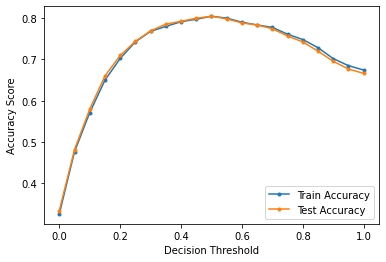

In [176]:
## Create a scores_df to store Accuracy Scores
score_df = pd.DataFrame(index=thresholds, columns=['Train Accuracy','Test Accuracy'])

## for each threshold:
for thresh in thresholds:

  ## Get the predicted classes for training and test data
  train_thresh = [1 if x[1] > thresh else 0 for x in train_probs]
  test_thresh = [1 if x[1] > thresh else 0 for x in test_probs]

  ## Save the Training and test accuracy scores to the score_df 
  score_df.loc[thresh, 'Train Accuracy'] = accuracy_score(train_thresh, y_train)
  score_df.loc[thresh, 'Test Accuracy'] = accuracy_score(test_thresh, y_test)

## Plot the results
score_df.plot(marker='.')
plt.xlabel('Decision Threshold')
plt.ylabel('Accuracy Score')

In [177]:
## sorting the scores dataframe
score_df.sort_values(by='Test Accuracy', ascending=False).head()

,Train Accuracy,Test Accuracy
0.50,0.804822,0.80483
0.45,0.797581,0.799978
0.55,0.800301,0.798434
0.40,0.791553,0.79259
0.60,0.790304,0.788621


### **ROC Curve**

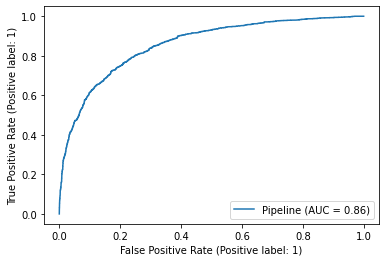

In [179]:
## Display the ROC Curve
RocCurveDisplay.from_estimator(logreg_pipe, X_test, y_test);

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.90      0.86     18347
           1       0.74      0.62      0.67      8859

    accuracy                           0.80     27206
   macro avg       0.78      0.76      0.77     27206
weighted avg       0.80      0.80      0.80     27206



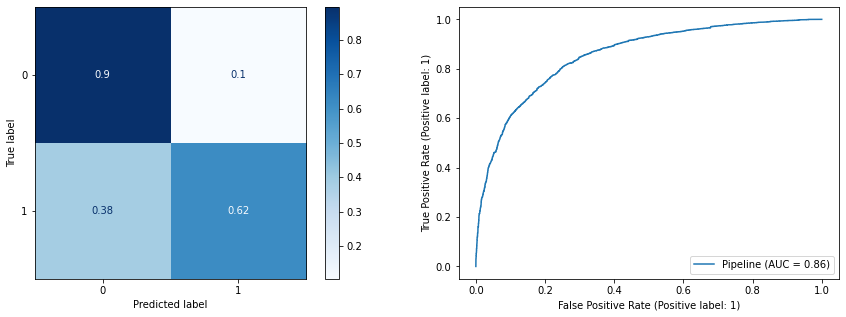

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      6043
           1       0.76      0.61      0.68      3026

    accuracy                           0.80      9069
   macro avg       0.79      0.76      0.77      9069
weighted avg       0.80      0.80      0.80      9069



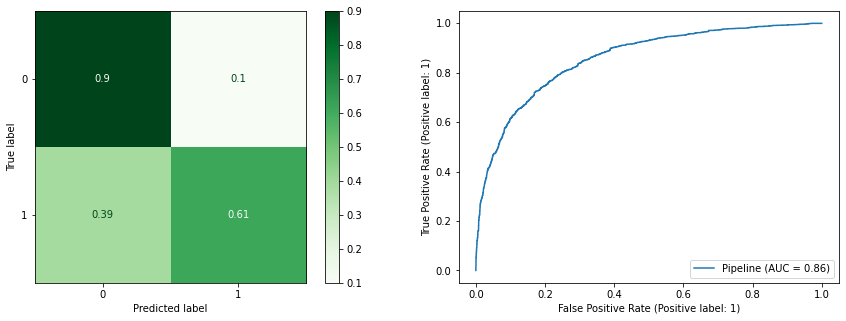

In [191]:
## Use the function twice to evaluate our model on training AND test data
classification_metrics(logreg_pipe, X_train,y_train, 
                         cmap='Blues', label='Training Data')
classification_metrics(logreg_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

## **K-Nearest Neighbor**

In [189]:
# create an instance of the model
knn = KNeighborsClassifier()
# create model pipeline
knn_pipe = make_pipeline(scaler,knn)
# fit the model
knn_pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])